## Inverse Kinematics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import math as m
import random
import csv
import cv2
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

l1 = l2 = l3 = 7

Generating the Work Space

In [2]:
def threeLinkManipulatorFile():
    data = []
    for i in range(1, 150000):
        q1 = round(random.uniform(0, m.pi), 2)
        q2 = round(random.uniform(-m.pi, 0), 2)
        q3 = round(random.uniform(-m.pi / 2, m.pi / 2))

        theta_o = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
        x_s = round(l1 * m.cos(q1) + l2 * m.cos(q1 + q2) + l3 * m.cos(q1 + q2 + q3), 2)
        y_s = round(l1 * m.sin(q1) + l2 * m.sin(q1 + q2) + l3 * m.sin(q1 + q2 + q3), 2)
        data.append([x_s, y_s, theta_o, q1, q2, q3])

    df = pd.DataFrame(data, columns=['x_scaled', 'y_scaled', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated'])

    df.to_csv('Three Link.csv', index = False)

threeLinkManipulatorFile()

Visualising the Work Space

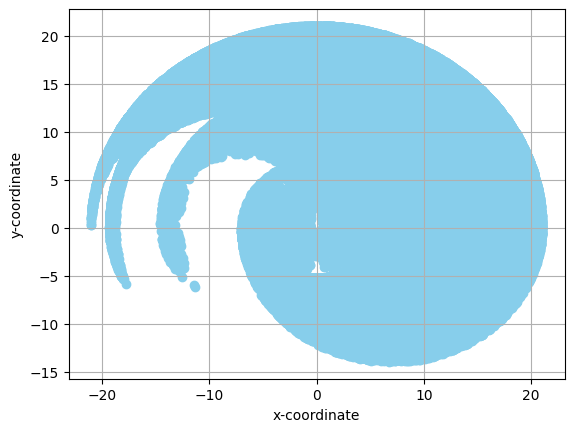

In [3]:
def displayWorkSpace():
    data = pd.read_csv('Three Link.csv')
    plt.scatter(data['x_scaled'], data['y_scaled'], color = 'skyblue')
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')
    plt.grid()

displayWorkSpace()

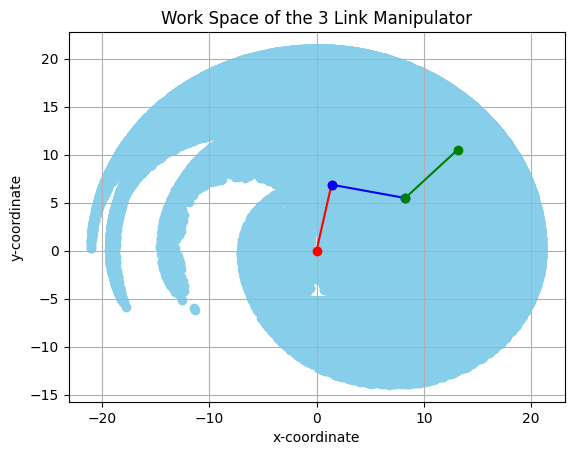

In [4]:
displayWorkSpace()
point_1_x = l1 * m.cos(1.37)
point_1_y = l1 * m.sin(1.37)
point_2_x = l1 * m.cos(1.37) + l2 * m.cos(1.37 - 1.57)
point_2_y = l1 * m.sin(1.37) + l2 * m.sin(1.37 - 1.57)
point_3_x = l1 * m.cos(1.37) + l2 * m.cos(1.37 - 1.57) + l3 * m.cos(1.37 - 1.57 + 1)
point_3_y = l1 * m.sin(1.37) + l2 * m.sin(1.37 - 1.57) + l3 * m.sin(1.37 - 1.57 + 1)
x_values_1 = [0, point_1_x]
y_values_1 = [0, point_1_y]
plt.plot(x_values_1, y_values_1, 'ro', linestyle='-')
x_values_2 = [point_1_x, point_2_x]
y_values_2 = [point_1_y, point_2_y]
plt.plot(x_values_2, y_values_2, 'bo', linestyle='-')
x_values_3 = [point_2_x, point_3_x]
y_values_3 = [point_2_y, point_3_y]
plt.title("Work Space of the 3 Link Manipulator")
plt.plot(x_values_3, y_values_3, 'go', linestyle='-')

Training the Artificial Neural Network Model

In [5]:
data = pd.read_csv('Three Link.csv')

x = data.iloc[:, 0:3].values
y = data.iloc[:, 3:].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

In [6]:
classifier = Sequential()
classifier.add(Dense(units = 3, input_dim = 3, kernel_initializer = 'uniform'))
classifier.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 3, kernel_initializer = 'uniform', activation = 'linear'))
classifier.compile(optimizer = 'adam', loss = tf.keras.losses.MeanSquaredError(), metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 12        
                                                                 
 dense_1 (Dense)             (None, 100)               400       
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 3)                 303       
                                                                 
Total params: 10815 (42.25 KB)
Trainable params: 10815 (42.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = classifier.fit(x_train, y_train, epochs = 150, validation_split = 0.1, shuffle = True, callbacks=[early_stopping])

Epoch 1/150
3375/3375 [==============================] - 5s 1ms/step - loss: 0.1683 - accuracy: 0.9334 - val_loss: 0.0306 - val_accuracy: 0.9678
Epoch 2/150
3375/3375 [==============================] - 4s 1ms/step - loss: 0.0289 - accuracy: 0.9670 - val_loss: 0.0303 - val_accuracy: 0.9748
Epoch 3/150
3375/3375 [==============================] - 4s 1ms/step - loss: 0.0213 - accuracy: 0.9744 - val_loss: 0.0170 - val_accuracy: 0.9819
Epoch 4/150
3375/3375 [==============================] - 4s 1ms/step - loss: 0.0188 - accuracy: 0.9776 - val_loss: 0.0245 - val_accuracy: 0.9737
Epoch 5/150
3375/3375 [==============================] - 4s 1ms/step - loss: 0.0177 - accuracy: 0.9789 - val_loss: 0.0149 - val_accuracy: 0.9847
Epoch 6/150
3375/3375 [==============================] - 4s 1ms/step - loss: 0.0167 - accuracy: 0.9791 - val_loss: 0.0197 - val_accuracy: 0.9737
Epoch 7/150
3375/3375 [==============================] - 5s 1ms/step - loss: 0.0158 - accuracy: 0.9802 - val_loss: 0.0155 - val_ac

Model Evaluation

In [8]:
test_loss, test_acc = classifier.evaluate(x_test, y_test)
print('Testing the Model :')
print('Testing Loss =', test_loss)
print('Testing Accuracy =', test_acc)

938/938 [==============================] - 1s 733us/step - loss: 0.0034 - accuracy: 0.9937
Testing the Model :
Testing Loss = 0.0034133694134652615
Testing Accuracy = 0.9937000274658203


Plot of Model Accuracy

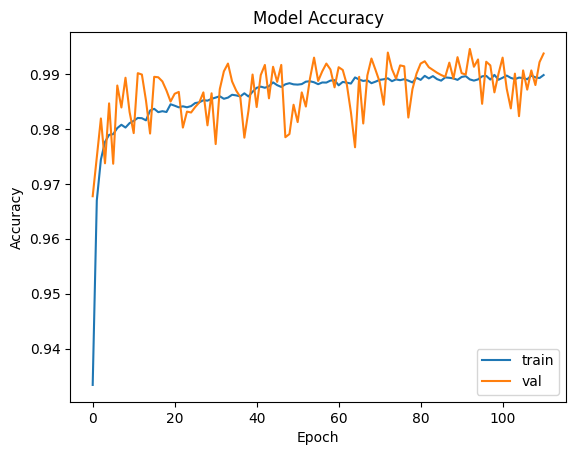

<Figure size 2200x2200 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.figure(figsize=(22,22))
plt.show()

Plot of Model Loss

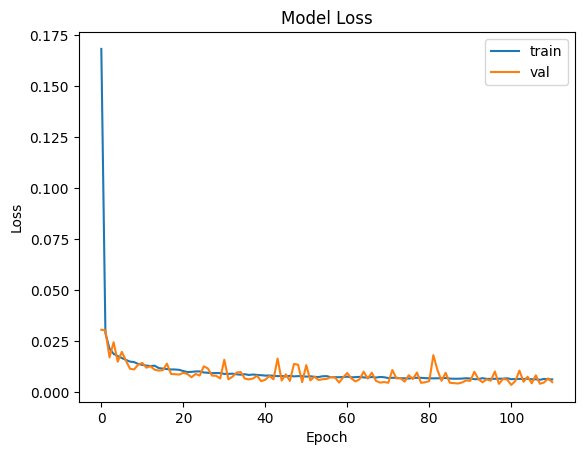

<Figure size 2200x2200 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.figure(figsize=(22,22))
plt.show()

Function for plotting a square representing the Confined Work Space

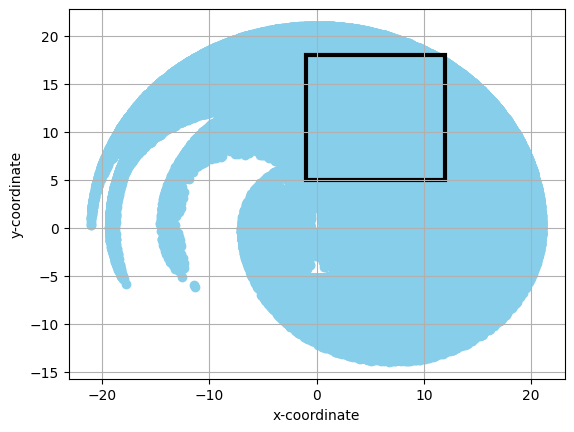

In [11]:
xmin = -1
xmax = 12
ymin = 5
ymax = 18

def displayConfinedWorkSpace():
    rect=mpatches.Rectangle((xmin,ymin),13,13, 
                            fill = False,
                            color = "black",
                            linewidth = 3)
    plt.gca().add_patch(rect)

displayWorkSpace()
displayConfinedWorkSpace()

## GENERATING A PLOT FROM INPUT CSV FILE

In [12]:
if not os.path.exists("CSV_Generated"):
    os.makedirs("CSV_Generated")

Generating a CSV File for a Circle

In [13]:
def circleFile():
    with open('CSV_Generated/Random Generate_Circle.csv', 'w') as csvFile:
        row = ['x_original','y_original', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated', 'x_predicted','y_predicted', 'theta_predicted', 'q1_predicted', 'q2_predicted', 'q3_predicted', 'x_scaled', 'y_scaled']
        csv.writer(csvFile).writerow(row)
        Xc = 10
        Yc = 10
        r = 5
        data_points = 100
        points = np.linspace(0,360,num = data_points)
        x = []
        y = []
        for p in points:
            i=Xc + r * m.cos(np.radians(p))
            x.append(i)
            j=Yc + r * m.sin(np.radians(p))
            y.append(j)

        xmin = -1
        xmax = 12
        ymin = 5
        ymax = 18

        min_xe = np.min(x)
        max_xe = np.max(x)
        min_ye = np.min(y)
        max_ye = np.max(y)

        scaling_factor_x = (xmax - xmin) / (max_xe - min_xe)
        scaling_factor_y = (ymax - ymin) / (max_ye - min_ye)

        for q in range(len(x)):
            theta=m.degrees(m.atan(y[q]/x[q]))
            new_x=np.array([[x[q], y[q], theta]])
            new_y=classifier.predict(new_x)
            q1=float(new_y[0][0])
            q2=float(new_y[0][1])
            q3=float(new_y[0][2])

            theta_p = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
            x_p = round(l1 * m.cos(q1) + l2 * m.cos(q1+q2) + l3 * m.cos(q1+q2+q3), 2)
            y_p = round(l1 * m.sin(q1) + l2 * m.sin(q1+q2) + l3 * m.sin(q1+q2+q3), 2)

            x3 = x_p
            y3 = y_p
            phi = np.radians(theta_p)
            x2 = x3 - l3 * np.cos(phi)
            y2 = y3 - l3 * np.sin(phi)
            c2 = (x2 ** 2 + y2 ** 2 - l1 ** 2 - l2 ** 2) / (2 * l1 * l2)
            s2 = m.sqrt(1 - c2 ** 2)
            q2_p = (-1) * np.arctan2(s2, c2)
            s1 = ((l1 + l2 * c2) * y2 - l2 * s2 * x2) / (l2 ** 2 + l3 ** 2)
            c1 = ((l1 + l2 * c2) * x2 + l2 * s2 * y2) / (l2 ** 2 + l3 ** 2)
            q1_p = np.arctan2(s1, c1)
            q3_p = phi - q1_p - q2_p

            if abs(q3_p) > m.pi / 2 :
                q3_p = m.pi - abs(q3_p)
                q1_p = phi - q2_p - q3_p

            i = (x_p - min_xe) * min(scaling_factor_x, scaling_factor_y) * 0.80 + xmin
            j = (y_p - min_ye) * min(scaling_factor_x, scaling_factor_y) * 0.80 + ymin
            
            row = [x[q], y[q], theta, q1, q2, q3, x_p, y_p, theta_p, q1_p, q2_p, q3_p, i, j]
            csv.writer(csvFile).writerow(row)     
    csvFile.close()

circleFile()

1/1 [==============================] - 0s 16ms/step


Plot a Circle Using its CSV File

<Figure size 1500x1500 with 0 Axes>

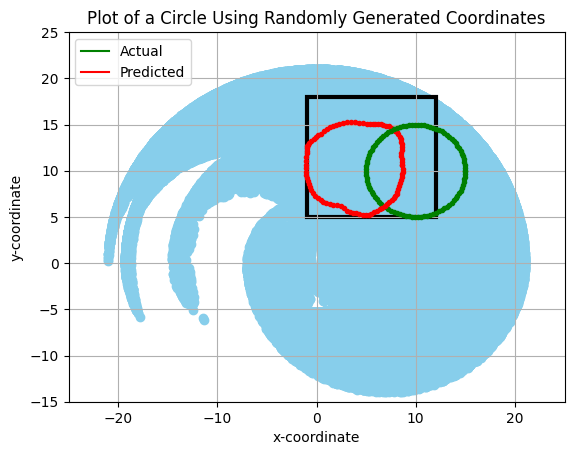

<Figure size 1500x1500 with 0 Axes>

In [14]:
filename = 'CSV_Generated/Random Generate_Circle.csv'
data = np.loadtxt(filename, delimiter=",", skiprows=1)

x = [row[0] for row in data]
y = [row[1] for row in data]

x_s = [row[12] for row in data]
y_s = [row[13] for row in data]

displayWorkSpace()
displayConfinedWorkSpace()
for i in range(len(data)):
    plt.plot(x[i], y[i], 'go', markersize = 3)
    plt.plot(x_s[i], y_s[i], 'ro', markersize = 3)
    plt.xlim([-25, 25])
    plt.ylim([-15, 25])
    
plt.plot(20, 20, 'g', label='Actual')
plt.plot(20, 20, 'r', label='Predicted')
plt.title('Plot of a Circle Using Randomly Generated Coordinates')
plt.legend(loc='upper left')
plt.figure(figsize=(15,15))
# plt.savefig('Random Generate_Circle Plot.png')

In [15]:
def getPerformanceModel(filename):
    data=pd.read_csv(filename)

    X_true=data['x_original']
    X_pred=data['x_predicted']
    Y_true=data['y_original']
    Y_pred=data['y_predicted']
    q1_true=data['q1_estimated']
    q1_pred=data['q1_predicted']
    q2_true=data['q2_estimated']
    q2_pred=data['q2_predicted']
    q3_true=data['q3_estimated']
    q3_pred=data['q3_predicted']
    theta_true=data['theta_scaled']
    theta_pred=data['theta_predicted']

    mse_x=mean_squared_error(X_true,X_pred)
    mse_y=mean_squared_error(Y_true,Y_pred) 
    mse_q1=mean_squared_error(q1_true,q1_pred)
    mse_q2=mean_squared_error(q2_true,q2_pred) 
    mse_q3=mean_squared_error(q3_true,q3_pred)
    mse_theta=mean_squared_error(theta_true,theta_pred) 
    print('Mean Squared Error in x  :', mse_x) 
    print('Mean Squared Error in y  :', mse_y)
    print('Mean Squared Error in q1 :', mse_q1) 
    print('Mean Squared Error in q2 :', mse_q2)
    print('Mean Squared Error in q3 :', mse_q3)
    print('Mean Squared Error in theta :', mse_theta)
    print()

    rmse_x = m.sqrt(mse_x)
    rmse_y = m.sqrt(mse_y)
    rmse_q1 = m.sqrt(mse_q1)
    rmse_q2 = m.sqrt(mse_q2)
    rmse_q3 = m.sqrt(mse_q3)
    rmse_theta = m.sqrt(mse_theta)
    print('Root Mean Squared Error in x :', rmse_x) 
    print('Root Mean Squared Error in y :', rmse_y)
    print('Root Mean Squared Error in q1 :', rmse_q1) 
    print('Root Mean Squared Error in q2 :', rmse_q2)
    print('Root Mean Squared Error in q3 :', rmse_q3)
    print('Root Mean Squared Error in theta :', rmse_theta)
    print()

    mae_x=mean_absolute_error(X_true,X_pred)
    mae_y=mean_absolute_error(Y_true,Y_pred)
    mae_q1=mean_absolute_error(q1_true,q1_pred)
    mae_q2=mean_absolute_error(q2_true,q2_pred)
    mae_q3=mean_absolute_error(q3_true,q3_pred)
    mae_theta=mean_absolute_error(theta_true,theta_pred)
    print('Mean Absolute Error in x :', mae_x) 
    print('Mean Absolute Error in y :', mae_y)
    print('Mean Absolute Error in q1 :', mae_q1) 
    print('Mean Absolute Error in q2 :', mae_q2)
    print('Mean Absolute Error in q3 :', mae_q3)
    print('Mean Absolute Error in theta :', mae_theta)
    print()

    print('R2 Score for x :', r2_score(X_true, X_pred)) 
    print('R2 Score for y :', r2_score(Y_true, Y_pred))
    print('R2 Score for q1 :', r2_score(q1_true, q1_pred)) 
    print('R2 Score for q2 :', r2_score(q2_true, q2_pred))
    print('R2 Score for q3 :', r2_score(q3_true, q3_pred)) 
    print('R2 Score for theta :', r2_score(theta_true, theta_pred))
    print()

In [16]:
getPerformanceModel('CSV_Generated/Random Generate_Circle.csv')

Mean Squared Error in x  : 0.11717161720207919
Mean Squared Error in y  : 0.14703550006905755
Mean Squared Error in q1 : 1.6885145936062806
Mean Squared Error in q2 : 4.6089620006925133e-07
Mean Squared Error in q3 : 1.6885390360235712
Mean Squared Error in theta : 1.150386397037274

Root Mean Squared Error in x : 0.3423033993434468
Root Mean Squared Error in y : 0.38345208314606605
Root Mean Squared Error in q1 : 1.29942856425672
Root Mean Squared Error in q2 : 0.0006788933642842971
Root Mean Squared Error in q3 : 1.299437969286557
Root Mean Squared Error in theta : 1.0725606728932746

Mean Absolute Error in x : 0.2696145335940596
Mean Absolute Error in y : 0.34427280184107184
Mean Absolute Error in q1 : 1.1054786152268221
Mean Absolute Error in q2 : 0.0005490633409438861
Mean Absolute Error in q3 : 1.1055447206570255
Mean Absolute Error in theta : 0.8872150394804978

R2 Score for x : 0.9907172416556087
R2 Score for y : 0.988118343428763
R2 Score for q1 : -9.072535932738887
R2 Score f

Generating a CSV File for the word "MANIT"

In [17]:
def manitFile():
    x = []
    y = []
    # for M
    arr=np.linspace(7,10,100)
    for j in arr:
        i = 7
        x.append(i-1)
        y.append(j)

    arr=np.linspace(7,8,100)
    for i in arr:
        j = -3*i + 31
        x.append(i-1)
        y.append(j)

    arr=np.linspace(8,9,100)
    for i in arr:
        j = 3*i - 17
        x.append(i-1)
        y.append(j)
        
    arr=np.linspace(7,10,100)
    for j in arr:
        i = 9
        x.append(i-1)
        y.append(j)

    # for A
    arr=np.linspace(10,11,100)
    for i in arr:
        j = 3*i - 23
        x.append(i-1)
        y.append(j)
        
    arr=np.linspace(11,12,100)
    for i in arr:
        j= -3*i + 43
        x.append(i-1)
        y.append(j)

    arr=np.linspace(10,12,100)
    for i in arr:
        j = 8
        x.append(i-1)
        y.append(j)

    # for N
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 13
        x.append(i-1)
        y.append(j)

    arr=np.linspace(13,15,100)
    for i in arr:
        j = -1.5*i + 29.5
        x.append(i-1)
        y.append(j)
        
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 15
        x.append(i-1)
        y.append(j)


    # for I
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 16
        x.append(i-1)
        y.append(j)
        
    # for T
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 17
        x.append(i)
        y.append(j)
            
    arr=np.linspace(16,18,100)
    for i in arr:
        j=10
        x.append(i)
        y.append(j)

    xmin = -1
    xmax = 12
    ymin = 5
    ymax = 18

    min_xe = np.min(x)
    max_xe = np.max(x)
    min_ye = np.min(y)
    max_ye = np.max(y)

    scaling_factor_x = (xmax - xmin) / (max_xe - min_xe)
    scaling_factor_y = (ymax - ymin) / (max_ye - min_ye)

    with open('CSV_Generated/Random Generate_MANIT.csv', 'w') as csvFile:
        row = ['x_original','y_original', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated', 'x_predicted','y_predicted', 'theta_predicted', 'q1_predicted', 'q2_predicted', 'q3_predicted', 'x_scaled', 'y_scaled']
        csv.writer(csvFile).writerow(row)
        for q in range(len(x)):
            theta=m.degrees(m.atan(y[q]/x[q]))

            new_x=np.array([[x[q], y[q], theta]])
            new_y=classifier.predict(new_x)
            q1=float(new_y[0][0])
            q2=float(new_y[0][1])
            q3=float(new_y[0][2])

            theta_p = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
            x_p = round(l1 * m.cos(q1) + l2 * m.cos(q1+q2) + l3 * m.cos(q1+q2+q3), 2)
            y_p = round(l1 * m.sin(q1) + l2 * m.sin(q1+q2) + l3 * m.sin(q1+q2+q3), 2)

            x3 = x_p
            y3 = y_p
            phi = np.radians(theta_p)
            x2 = x3 - l3 * np.cos(phi)
            y2 = y3 - l3 * np.sin(phi)
            c2 = (x2 ** 2 + y2 ** 2 - l1 ** 2 - l2 ** 2) / (2 * l1 * l2)
            s2 = m.sqrt(1 - c2 ** 2)
            q2_p = (-1) * np.arctan2(s2, c2)
            s1 = ((l1 + l2 * c2) * y2 - l2 * s2 * x2) / (l2 ** 2 + l3 ** 2)
            c1 = ((l1 + l2 * c2) * x2 + l2 * s2 * y2) / (l2 ** 2 + l3 ** 2)
            q1_p = np.arctan2(s1, c1)
            q3_p = phi - q1_p - q2_p

            if abs(q3_p) > m.pi / 2 :
                q3_p = m.pi - abs(q3_p)
                q1_p = phi - q2_p - q3_p

            i = (x_p - min_xe) * min(scaling_factor_x, scaling_factor_y) * 0.80 + xmin
            j = (y_p - min_ye) * min(scaling_factor_x, scaling_factor_y) * 0.80 + ymin
            
            row = [x[q], y[q], theta, q1, q2, q3, x_p, y_p, theta_p, q1_p, q2_p, q3_p, i, j]
            csv.writer(csvFile).writerow(row)
    csvFile.close()
manitFile()

1/1 [==============================] - 0s 15ms/step


Function for Plotting (After Transformation of Axes and Scaling) Using the CSV File

In [18]:
def plotCoordinateFile(FilePath, PlotTitle):
    filename = FilePath
    data = np.loadtxt(filename, delimiter = ",", skiprows = 1)

    x = [row[0] for row in data]
    y = [row[1] for row in data]

    x_s = [row[12] for row in data]
    y_s = [row[13] for row in data]
    
    i = 1
    displayWorkSpace()
    displayConfinedWorkSpace()

    for i in range(len(data)):
        plt.xlim([-25,30])
        plt.ylim([-15,20])
        plt.plot(x[i], y[i], 'go', markersize = 1.5)
        plt.plot(x_s[i], y_s[i], 'ro', markersize = 1.5)
    
    plt.plot(20, 20, 'g', label='Actual')
    plt.plot(20, 20, 'r', label='Predicted')
    plt.title(PlotTitle)
    plt.legend(loc='upper left')
    plt.figure(figsize=(15,15))

Plot the word MANIT Using its CSV File after Scaling and Transformation of Axes

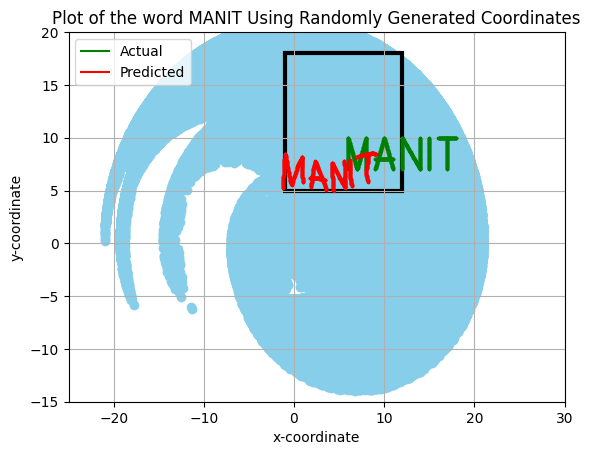

<Figure size 1500x1500 with 0 Axes>

In [19]:
plotCoordinateFile("CSV_Generated/Random Generate_MANIT.csv", 'Plot of the word MANIT Using Randomly Generated Coordinates')

In [20]:
getPerformanceModel("CSV_Generated/Random Generate_MANIT.csv")

Mean Squared Error in x  : 0.09481190028490029
Mean Squared Error in y  : 0.41056318881118875
Mean Squared Error in q1 : 1.39974658722065
Mean Squared Error in q2 : 4.1257229782893965e-07
Mean Squared Error in q3 : 1.3997150243621115
Mean Squared Error in theta : 1.491016476401976

Root Mean Squared Error in x : 0.30791541092465685
Root Mean Squared Error in y : 0.6407520494006935
Root Mean Squared Error in q1 : 1.1831088653292434
Root Mean Squared Error in q2 : 0.0006423179102507883
Root Mean Squared Error in q3 : 1.1830955263046647
Root Mean Squared Error in theta : 1.2210718555441264

Mean Absolute Error in x : 0.2409181818181818
Mean Absolute Error in y : 0.5300731934731934
Mean Absolute Error in q1 : 1.0456712060803408
Mean Absolute Error in q2 : 0.00046412622468631223
Mean Absolute Error in q3 : 1.045670169415302
Mean Absolute Error in theta : 1.0074958289723688

R2 Score for x : 0.9928617058324121
R2 Score for y : 0.5076155251868182
R2 Score for q1 : -6.975700329429339
R2 Score 

Generating a CSV File for the word "ROBOT"

In [21]:
def makeCircle(Xcentre, Ycentre, radius, start, end, x, y):
    Xc = Xcentre
    Yc = Ycentre
    r = radius
    data_points = 100
    points = np.linspace(start,end,num =data_points)
    for p in points:
        i=Xc + r*m.cos(np.radians(p))
        j=Yc + r*m.sin(np.radians(p))
        x.append(i)
        y.append(j)

def robotFile():
    x = []
    y = []

    # for R
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 5
        x.append(i)
        y.append(j)
    
    makeCircle(5, 9, 1, -90, 90, x, y)

    arr=np.linspace(5,6,100)
    for i in arr:
        j= -i + 13
        x.append(i)
        y.append(j)

    # for O
    makeCircle(8, 8, 1, 0, 360, x, y)

    # for B
    arr=np.linspace(6,10,100) # 6, 10
    for j in arr:
        i= 10 # 10
        x.append(i)
        y.append(j)
        
    makeCircle(10, 7, 1, -90, 90, x, y)
        
    makeCircle(10, 9, 1, -90, 90, x, y)
        
    # for O
    makeCircle(13, 8, 1, 0, 360, x, y)

    # for T
    arr=np.linspace(7,10,100)
    for j in arr:
        i= 15
        x.append(i)
        y.append(j)
    
    arr=np.linspace(14,16,100)
    for i in arr:
        j=10
        x.append(i)
        y.append(j)


    xmin = -1
    xmax = 12
    ymin = 5
    ymax = 18

    min_xe = np.min(x)
    max_xe = np.max(x)
    min_ye = np.min(y)
    max_ye = np.max(y)

    scaling_factor_x = (xmax - xmin) / (max_xe - min_xe)
    scaling_factor_y = (ymax - ymin) / (max_ye - min_ye)

    with open('CSV_Generated/Random Generate_ROBOT.csv', 'w') as csvFile:
        row = ['x_original','y_original', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated', 'x_predicted','y_predicted', 'theta_predicted', 'q1_predicted', 'q2_predicted', 'q3_predicted', 'x_scaled', 'y_scaled']
        csv.writer(csvFile).writerow(row)
        for q in range(len(x)):
            theta=m.degrees(m.atan(y[q]/x[q]))

            new_x=np.array([[x[q], y[q], theta]])
            new_y=classifier.predict(new_x)
            q1=float(new_y[0][0])
            q2=float(new_y[0][1])
            q3=float(new_y[0][2])

            theta_p = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
            x_p = round(l1 * m.cos(q1) + l2 * m.cos(q1+q2) + l3 * m.cos(q1+q2+q3), 2)
            y_p = round(l1 * m.sin(q1) + l2 * m.sin(q1+q2) + l3 * m.sin(q1+q2+q3), 2)

            x3 = x_p
            y3 = y_p
            phi = np.radians(theta_p)
            x2 = x3 - l3 * np.cos(phi)
            y2 = y3 - l3 * np.sin(phi)
            c2 = (x2 ** 2 + y2 ** 2 - l1 ** 2 - l2 ** 2) / (2 * l1 * l2)
            s2 = m.sqrt(1 - c2 ** 2)
            q2_p = (-1) * np.arctan2(s2, c2)
            s1 = ((l1 + l2 * c2) * y2 - l2 * s2 * x2) / (l2 ** 2 + l3 ** 2)
            c1 = ((l1 + l2 * c2) * x2 + l2 * s2 * y2) / (l2 ** 2 + l3 ** 2)
            q1_p = np.arctan2(s1, c1)
            q3_p = phi - q1_p - q2_p

            if abs(q3_p) > m.pi / 2 :
                q3_p = m.pi - abs(q3_p)
                q1_p = phi - q2_p - q3_p

            i = (x_p - min_xe) * min(scaling_factor_x, scaling_factor_y) * 0.80 + xmin
            j = (y_p - min_ye) * min(scaling_factor_x, scaling_factor_y) * 0.80 + ymin
            
            row = [x[q], y[q], theta, q1, q2, q3, x_p, y_p, theta_p, q1_p, q2_p, q3_p, i, j]
            csv.writer(csvFile).writerow(row)
    csvFile.close()
robotFile()

1/1 [==============================] - 0s 22ms/step


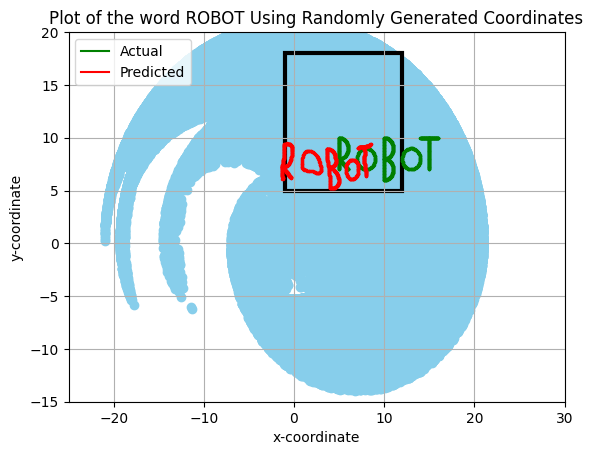

<Figure size 1500x1500 with 0 Axes>

In [22]:
plotCoordinateFile("CSV_Generated/Random Generate_ROBOT.csv", 'Plot of the word ROBOT Using Randomly Generated Coordinates')

In [23]:
getPerformanceModel("CSV_Generated/Random Generate_ROBOT.csv")

Mean Squared Error in x  : 0.12944991714086995
Mean Squared Error in y  : 0.19461337085167257
Mean Squared Error in q1 : 1.9765135750819924
Mean Squared Error in q2 : 2.2958506296680173e-07
Mean Squared Error in q3 : 1.9764729207587364
Mean Squared Error in theta : 0.8269774832987898

Root Mean Squared Error in x : 0.3597914912013206
Root Mean Squared Error in y : 0.44115005480184694
Root Mean Squared Error in q1 : 1.4058853349693894
Root Mean Squared Error in q2 : 0.0004791503552819321
Root Mean Squared Error in q3 : 1.405870876275178
Root Mean Squared Error in theta : 0.9093830234278567

Mean Absolute Error in x : 0.2791744945057493
Mean Absolute Error in y : 0.3754230661777804
Mean Absolute Error in q1 : 1.2304460405142663
Mean Absolute Error in q2 : 0.00039486817552920693
Mean Absolute Error in q3 : 1.2304406184509162
Mean Absolute Error in theta : 0.6860352922236577

R2 Score for x : 0.9900143125656621
R2 Score for y : 0.837897693153731
R2 Score for q1 : -10.018261317797451
R2 Sco

Plot a Circle Using its CSV File after Scaling and Transformation of Axes

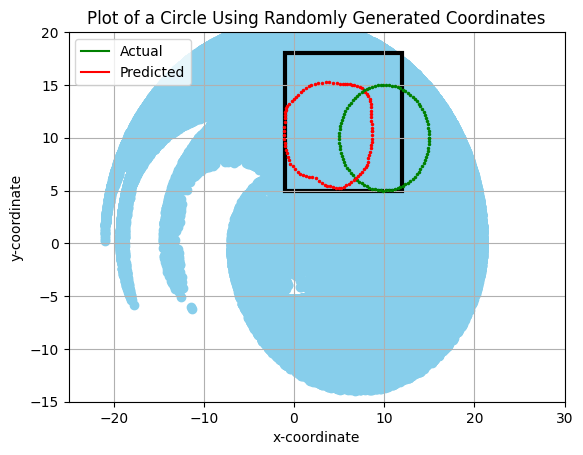

<Figure size 1500x1500 with 0 Axes>

In [24]:
plotCoordinateFile("CSV_Generated/Random Generate_Circle.csv", 'Plot of a Circle Using Randomly Generated Coordinates')

In [25]:
getPerformanceModel("CSV_Generated/Random Generate_Circle.csv")

Mean Squared Error in x  : 0.11717161720207919
Mean Squared Error in y  : 0.14703550006905755
Mean Squared Error in q1 : 1.6885145936062806
Mean Squared Error in q2 : 4.6089620006925133e-07
Mean Squared Error in q3 : 1.6885390360235712
Mean Squared Error in theta : 1.150386397037274

Root Mean Squared Error in x : 0.3423033993434468
Root Mean Squared Error in y : 0.38345208314606605
Root Mean Squared Error in q1 : 1.29942856425672
Root Mean Squared Error in q2 : 0.0006788933642842971
Root Mean Squared Error in q3 : 1.299437969286557
Root Mean Squared Error in theta : 1.0725606728932746

Mean Absolute Error in x : 0.2696145335940596
Mean Absolute Error in y : 0.34427280184107184
Mean Absolute Error in q1 : 1.1054786152268221
Mean Absolute Error in q2 : 0.0005490633409438861
Mean Absolute Error in q3 : 1.1055447206570255
Mean Absolute Error in theta : 0.8872150394804978

R2 Score for x : 0.9907172416556087
R2 Score for y : 0.988118343428763
R2 Score for q1 : -9.072535932738887
R2 Score f

## GENERATING A PLOT FROM INPUT IMAGE FILE

In [26]:
if not os.path.exists("Image_Generated"):
    os.makedirs("Image_Generated")

Function for Generating a CSV File from an Image

In [27]:
def generateCoordinateFile(FilePath, RepositoryName, name):
    image = cv2.imread(FilePath)

    target_color = (0, 0, 0)
    x = []
    y = []
    height, width, _ = image.shape
    for j in range(height):
        for i in range(width):
            pixel_color = tuple(image[j, i])
            if pixel_color == target_color:
                x.append(i)
                y.append(height - j)

    xmin = -1
    xmax = 12
    ymin = 5
    ymax = 18

    min_x = np.min(x)
    max_x = np.max(x)
    min_y = np.min(y)
    max_y = np.max(y)

    scaling_factor_x = 10 * (xmax - xmin) / (max_x - min_x)
    scaling_factor_y = 10 * (ymax - ymin) / (max_y - min_y)

    output_file = str(RepositoryName) + "/Image Generate_" + str(name) + ".csv"
    with open(output_file, "w", newline='') as csvfile:
        fieldnames = ['x_original','y_original', 'theta_scaled', 'q1_estimated', 'q2_estimated', 'q3_estimated', 'x_predicted','y_predicted', 'theta_predicted', 'q1_predicted', 'q2_predicted', 'q3_predicted', 'x_scaled', 'y_scaled']
        csv_writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
        csv_writer.writeheader()

        for k in range(len(x)):
            i = x[k] / 10
            j = y[k] / 10
            theta=m.degrees(m.atan(j / i))

            new_x=np.array([[i, j, theta]])
            new_y=classifier.predict(new_x)
            q1=float(new_y[0][0])
            q2=float(new_y[0][1])
            q3=float(new_y[0][2])

            theta_p = round(m.degrees(q1) + m.degrees(q2) + m.degrees(q3), 2)
            x_p = round(l1 * m.cos(q1) + l2 * m.cos(q1+q2) + l3 * m.cos(q1+q2+q3), 2)
            y_p = round(l1 * m.sin(q1) + l2 * m.sin(q1+q2) + l3 * m.sin(q1+q2+q3), 2)

            x3 = x_p
            y3 = y_p
            phi = np.radians(theta_p)
            x2 = x3 - l3 * np.cos(phi)
            y2 = y3 - l3 * np.sin(phi)
            c2 = (x2 ** 2 + y2 ** 2 - l1 ** 2 - l2 ** 2) / (2 * l1 * l2)
            s2 = m.sqrt(1 - c2 ** 2)
            q2_p = (-1) * np.arctan2(s2, c2)
            s1 = ((l1 + l2 * c2) * y2 - l2 * s2 * x2) / (l2 ** 2 + l3 ** 2)
            c1 = ((l1 + l2 * c2) * x2 + l2 * s2 * y2) / (l2 ** 2 + l3 ** 2)
            q1_p = np.arctan2(s1, c1)
            q3_p = phi - q1_p - q2_p

            if abs(q3_p) > m.pi / 2 :
                q3_p = m.pi - abs(q3_p)
                q1_p = phi - q2_p - q3_p

            x_s = (x_p - min_x / 10) * min(scaling_factor_x, scaling_factor_y) * 0.80 + xmin
            y_s = (y_p - min_y / 10) * min(scaling_factor_x, scaling_factor_y) * 0.80 + ymin

            csv_writer.writerow({'x_original': i, 'y_original': j, 'theta_scaled': theta, 'q1_estimated': q1, 'q2_estimated': q2, 'q3_estimated': q3, 'x_predicted': x_p, 'y_predicted': y_p, 'theta_predicted': theta_p, 'q1_predicted': q1_p, 'q2_predicted': q2_p, 'q3_predicted': q3_p, 'x_scaled': x_s, 'y_scaled': y_s})

Plotting the word "MANIT" from it's Image

In [28]:
generateCoordinateFile('Images/Image_MANIT.png', 'Image_Generated', 'MANIT')

1/1 [==============================] - 0s 18ms/step


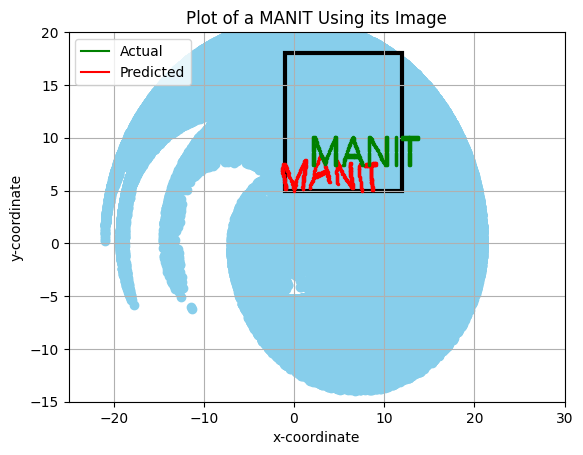

<Figure size 1500x1500 with 0 Axes>

In [29]:
plotCoordinateFile("Image_Generated/Image Generate_MANIT.csv", 'Plot of a MANIT Using its Image')

In [30]:
getPerformanceModel("Image_Generated/Image Generate_MANIT.csv")

Mean Squared Error in x  : 0.026231491712707167
Mean Squared Error in y  : 0.2415458563535911
Mean Squared Error in q1 : 2.6344757044920826
Mean Squared Error in q2 : 1.9985887592765713e-07
Mean Squared Error in q3 : 2.6344047216921886
Mean Squared Error in theta : 0.484934007309175

Root Mean Squared Error in x : 0.16196138957389555
Root Mean Squared Error in y : 0.4914731491684883
Root Mean Squared Error in q1 : 1.623106806249078
Root Mean Squared Error in q2 : 0.0004470557861471621
Root Mean Squared Error in q3 : 1.6230849397650724
Root Mean Squared Error in theta : 0.6963720322565913

Mean Absolute Error in x : 0.13397790055248618
Mean Absolute Error in y : 0.3728545119705341
Mean Absolute Error in q1 : 1.4539402522147848
Mean Absolute Error in q2 : 0.00036435927887885124
Mean Absolute Error in q3 : 1.4539120910562398
Mean Absolute Error in theta : 0.4960595411801626

R2 Score for x : 0.9980111273333654
R2 Score for y : 0.6520051158793083
R2 Score for q1 : -12.17962976300555
R2 Sco

Plotting the word "ROBOT" from it's Image

In [31]:
generateCoordinateFile('Images/Image_ROBOT.png', 'Image_Generated', 'ROBOT')

1/1 [==============================] - 0s 1ms/step


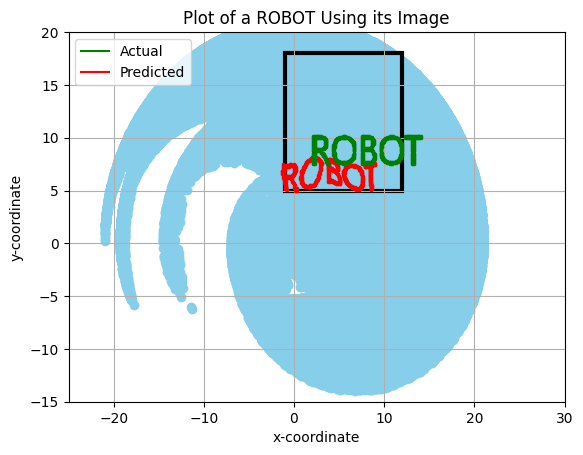

<Figure size 1500x1500 with 0 Axes>

In [32]:
plotCoordinateFile("Image_Generated/Image Generate_ROBOT.csv", 'Plot of a ROBOT Using its Image')

In [33]:
getPerformanceModel("Image_Generated/Image Generate_ROBOT.csv")

Mean Squared Error in x  : 0.03092105868814729
Mean Squared Error in y  : 0.2544233601841197
Mean Squared Error in q1 : 2.5258939903537465
Mean Squared Error in q2 : 2.2035991460582541e-07
Mean Squared Error in q3 : 2.5258773349810144
Mean Squared Error in theta : 0.5757457783023154

Root Mean Squared Error in x : 0.17584384745605203
Root Mean Squared Error in y : 0.5044039652739852
Root Mean Squared Error in q1 : 1.589306134875766
Root Mean Squared Error in q2 : 0.0004694250894507295
Root Mean Squared Error in q3 : 1.5893008950419094
Root Mean Squared Error in theta : 0.7587791367073263

Mean Absolute Error in x : 0.14791714614499424
Mean Absolute Error in y : 0.3775258918296894
Mean Absolute Error in q1 : 1.4278899416641029
Mean Absolute Error in q2 : 0.0003928370749374981
Mean Absolute Error in q3 : 1.4278889602944518
Mean Absolute Error in theta : 0.5637915559319021

R2 Score for x : 0.9977144203461042
R2 Score for y : 0.6772518820055508
R2 Score for q1 : -11.480063858483348
R2 Sco

Plotting a Circle from it's Image

In [34]:
generateCoordinateFile('Images/Image_Circle.png', 'Image_Generated', 'Circle')

1/1 [==============================] - 0s 15ms/step


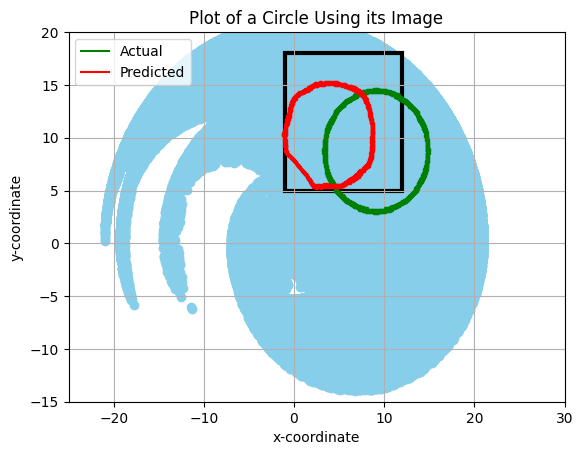

<Figure size 1500x1500 with 0 Axes>

In [35]:
plotCoordinateFile("Image_Generated/Image Generate_Circle.csv", 'Plot of a Circle Using its Image')

In [36]:
getPerformanceModel("Image_Generated/Image Generate_Circle.csv")

Mean Squared Error in x  : 0.10387373913043475
Mean Squared Error in y  : 0.1130961739130435
Mean Squared Error in q1 : 2.205892961282336
Mean Squared Error in q2 : 2.674961395851324e-07
Mean Squared Error in q3 : 2.2058827486789094
Mean Squared Error in theta : 1.151093258973519

Root Mean Squared Error in x : 0.3222944913125801
Root Mean Squared Error in y : 0.33629774592322725
Root Mean Squared Error in q1 : 1.4852248857605153
Root Mean Squared Error in q2 : 0.00051720028962205
Root Mean Squared Error in q3 : 1.4852214476901784
Root Mean Squared Error in theta : 1.0728901430125635

Mean Absolute Error in x : 0.2500173913043478
Mean Absolute Error in y : 0.2984695652173913
Mean Absolute Error in q1 : 1.2238937966190508
Mean Absolute Error in q2 : 0.0004246805214880053
Mean Absolute Error in q3 : 1.2238880634250715
Mean Absolute Error in theta : 0.8460086101202122

R2 Score for x : 0.9936978996304886
R2 Score for y : 0.9930433977972287
R2 Score for q1 : -6.712955964348814
R2 Score for

Plot a Triangle from its Image

In [37]:
generateCoordinateFile('Images/Image_Triangle.png', 'Image_Generated', 'Triangle')

1/1 [==============================] - 0s 13ms/step


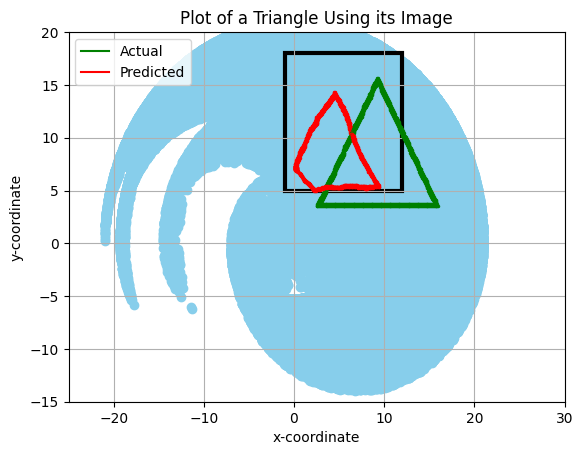

<Figure size 1500x1500 with 0 Axes>

In [38]:
plotCoordinateFile("Image_Generated/Image Generate_Triangle.csv", 'Plot of a Triangle Using its Image')

In [39]:
getPerformanceModel("Image_Generated/Image Generate_Triangle.csv")

Mean Squared Error in x  : 0.21623571996817817
Mean Squared Error in y  : 0.40472458233890213
Mean Squared Error in q1 : 2.3692911082267627
Mean Squared Error in q2 : 2.517595258477395e-07
Mean Squared Error in q3 : 2.369320473578131
Mean Squared Error in theta : 1.3597853454632522

Root Mean Squared Error in x : 0.4650115267046379
Root Mean Squared Error in y : 0.6361796777160539
Root Mean Squared Error in q1 : 1.5392501772703366
Root Mean Squared Error in q2 : 0.0005017564407635835
Root Mean Squared Error in q3 : 1.5392597160902155
Root Mean Squared Error in theta : 1.1660983429639424

Mean Absolute Error in x : 0.32500397772474154
Mean Absolute Error in y : 0.4330151153540175
Mean Absolute Error in q1 : 1.2336368702056333
Mean Absolute Error in q2 : 0.0004148557980412713
Mean Absolute Error in q3 : 1.2336520425965134
Mean Absolute Error in theta : 0.9439666823997169

R2 Score for x : 0.9848975836646303
R2 Score for y : 0.9743147917423801
R2 Score for q1 : -8.120385604905183
R2 Score

Plot a Pentagon from its Image

In [40]:
generateCoordinateFile('Images/Image_Pentagon.png', 'Image_Generated', 'Pentagon')

1/1 [==============================] - 0s 10ms/step


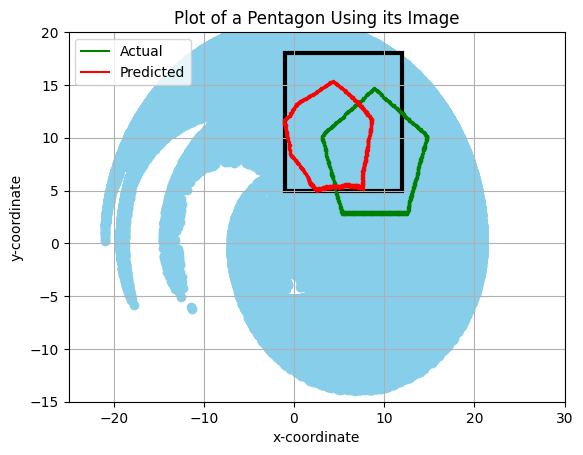

<Figure size 1500x1500 with 0 Axes>

In [41]:
plotCoordinateFile("Image_Generated/Image Generate_Pentagon.csv", 'Plot of a Pentagon Using its Image')

In [42]:
getPerformanceModel("Image_Generated/Image Generate_Pentagon.csv")

Mean Squared Error in x  : 0.14792739273927388
Mean Squared Error in y  : 0.13082079207920794
Mean Squared Error in q1 : 2.5758604474246027
Mean Squared Error in q2 : 2.2817565672559692e-07
Mean Squared Error in q3 : 2.5759039357664792
Mean Squared Error in theta : 0.9838180854005488

Root Mean Squared Error in x : 0.38461330286311457
Root Mean Squared Error in y : 0.3616915703734439
Root Mean Squared Error in q1 : 1.604948736696784
Root Mean Squared Error in q2 : 0.0004776773563040192
Root Mean Squared Error in q3 : 1.604962284842382
Root Mean Squared Error in theta : 0.9918760433645673

Mean Absolute Error in x : 0.3205280528052805
Mean Absolute Error in y : 0.3121782178217821
Mean Absolute Error in q1 : 1.3687875014498259
Mean Absolute Error in q2 : 0.0003919109413727754
Mean Absolute Error in q3 : 1.3687855730755925
Mean Absolute Error in theta : 0.7772737621770865

R2 Score for x : 0.9885634383553596
R2 Score for y : 0.9920827236083533
R2 Score for q1 : -8.689959352699043
R2 Score

Plot a Square from its Image

In [43]:
generateCoordinateFile('Images/Image_Square.png', 'Image_Generated', 'Square')

1/1 [==============================] - 0s 15ms/step


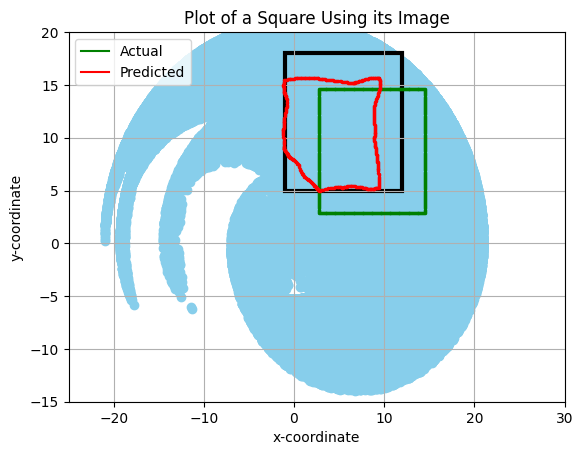

<Figure size 1500x1500 with 0 Axes>

In [44]:
plotCoordinateFile("Image_Generated/Image Generate_Square.csv", 'Plot of a Square Using its Image')

In [45]:
getPerformanceModel("Image_Generated/Image Generate_Square.csv")

Mean Squared Error in x  : 0.29656196581196587
Mean Squared Error in y  : 0.40259487179487186
Mean Squared Error in q1 : 2.386809583191444
Mean Squared Error in q2 : 5.370490479843773e-05
Mean Squared Error in q3 : 2.3869426429127407
Mean Squared Error in theta : 1.2390537213871293

Root Mean Squared Error in x : 0.5445750323068125
Root Mean Squared Error in y : 0.6345036420658843
Root Mean Squared Error in q1 : 1.5449302842495658
Root Mean Squared Error in q2 : 0.0073283630367523235
Root Mean Squared Error in q3 : 1.5449733469910543
Root Mean Squared Error in theta : 1.1131278998332264

Mean Absolute Error in x : 0.3732051282051282
Mean Absolute Error in y : 0.4370940170940171
Mean Absolute Error in q1 : 1.2137219784382116
Mean Absolute Error in q2 : 0.0016405665621942779
Mean Absolute Error in q3 : 1.2145086194168129
Mean Absolute Error in theta : 0.9141878715533702

R2 Score for x : 0.9870019226789014
R2 Score for y : 0.9823545839455844
R2 Score for q1 : -6.0644331900862225
R2 Score

Plot a Hexagon from its Image

In [46]:
generateCoordinateFile('Images/Image_Hexagon.png', 'Image_Generated', 'Hexagon')

1/1 [==============================] - 0s 14ms/step


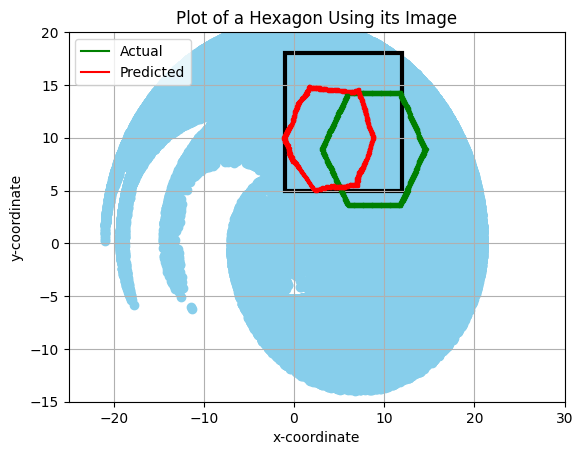

<Figure size 1500x1500 with 0 Axes>

In [47]:
plotCoordinateFile("Image_Generated/Image Generate_Hexagon.csv", 'Plot of a Hexagon Using its Image')

In [48]:
getPerformanceModel("Image_Generated/Image Generate_Hexagon.csv")

Mean Squared Error in x  : 0.0736726126126126
Mean Squared Error in y  : 0.09196414414414414
Mean Squared Error in q1 : 2.1804656052266163
Mean Squared Error in q2 : 2.665942357010204e-07
Mean Squared Error in q3 : 2.180395754431685
Mean Squared Error in theta : 0.9445086944703364

Root Mean Squared Error in x : 0.2714269931539835
Root Mean Squared Error in y : 0.30325590537390057
Root Mean Squared Error in q1 : 1.476639971430618
Root Mean Squared Error in q2 : 0.0005163276437505748
Root Mean Squared Error in q3 : 1.4766163193029138
Root Mean Squared Error in theta : 0.9718583716109752

Mean Absolute Error in x : 0.21636036036036033
Mean Absolute Error in y : 0.2604684684684685
Mean Absolute Error in q1 : 1.2098285197128569
Mean Absolute Error in q2 : 0.00042074871847859387
Mean Absolute Error in q3 : 1.2098086074892507
Mean Absolute Error in theta : 0.7375080675799508

R2 Score for x : 0.9947717882209094
R2 Score for y : 0.9939678861380646
R2 Score for q1 : -7.740150314063397
R2 Score

## GENERATING A PLOT FROM INPUT TEXT

In [49]:
if not os.path.exists("Text_Generated"):
    os.makedirs("Text_Generated")

In [50]:
def text_to_image(text, font_size, image_width, 
                  image_height, output_path) :

    image = Image.new("RGB", 
                      (image_width, image_height), 
                      (255, 255, 255))

    draw = ImageDraw.Draw(image)

    font = ImageFont.truetype("arial.ttf", font_size)

    _, _, text_width, text_height = draw.textbbox((0, 0), 
                                                  text=text, 
                                                  font=font)

    x = 60
    y = image_height - text_height - 30

    draw.text((x, y), text, font = font, fill = (0, 0, 0))

    image.save(output_path)

Plotting the Word "SAATVIK" from Text Input

In [51]:
text_to_image("SAATVIK", 30, 300, 100, "Text_Generated/Text Generate_SAATVIK.png")

In [52]:
generateCoordinateFile('Text_Generated/Text Generate_SAATVIK.png', 'Text_Generated', "SAATVIK")

1/1 [==============================] - 0s 23ms/step


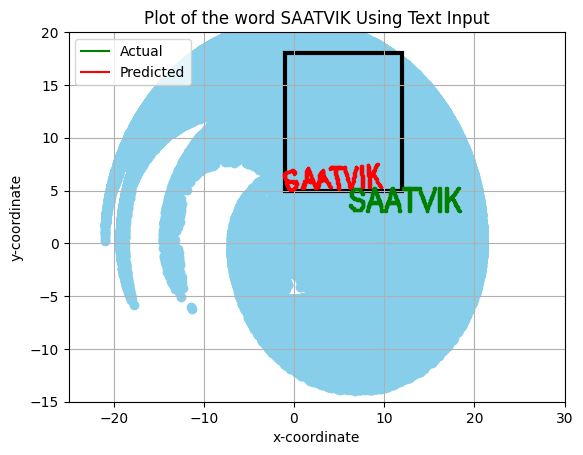

<Figure size 1500x1500 with 0 Axes>

In [53]:
plotCoordinateFile("Text_Generated/Image Generate_SAATVIK.csv", 'Plot of the word SAATVIK Using Text Input')

In [54]:
getPerformanceModel("Text_Generated/Image Generate_SAATVIK.csv")

Mean Squared Error in x  : 0.04764011406844106
Mean Squared Error in y  : 0.18557642585551332
Mean Squared Error in q1 : 2.5146293681801435
Mean Squared Error in q2 : 2.6227002407192195e-07
Mean Squared Error in q3 : 2.514579481955425
Mean Squared Error in theta : 2.2872032027866007

Root Mean Squared Error in x : 0.21826615419812817
Root Mean Squared Error in y : 0.4307858236473356
Root Mean Squared Error in q1 : 1.5857582943753261
Root Mean Squared Error in q2 : 0.0005121230555949634
Root Mean Squared Error in q3 : 1.5857425648431793
Root Mean Squared Error in theta : 1.5123502249104208

Mean Absolute Error in x : 0.1675855513307985
Mean Absolute Error in y : 0.39699619771863115
Mean Absolute Error in q1 : 1.343852290147611
Mean Absolute Error in q2 : 0.000417463596957939
Mean Absolute Error in q3 : 1.343836522068806
Mean Absolute Error in theta : 1.3352813957929148

R2 Score for x : 0.9963863720990258
R2 Score for y : 0.5458739640226735
R2 Score for q1 : -13.677092596871613
R2 Score

Plotting the Word "MANIT" from Text Input

In [79]:
text_to_image("MANIT", 30, 300, 100, "Text_Generated/Text Generate_MANIT.png")

In [80]:
generateCoordinateFile('Text_Generated/Text Generate_MANIT.png', 'Text_Generated', "MANIT")

1/1 [==============================] - 0s 20ms/step


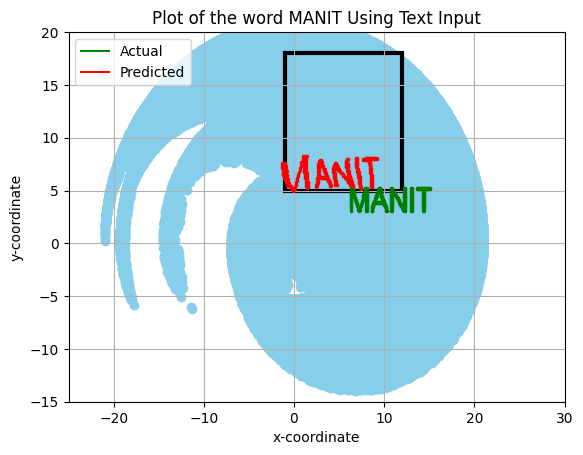

<Figure size 1500x1500 with 0 Axes>

In [81]:
plotCoordinateFile("Text_Generated/Image Generate_MANIT.csv", 'Plot of the word MANIT Using Text Input')

In [58]:
getPerformanceModel("Text_Generated/Image Generate_MANIT.csv")

Mean Squared Error in x  : 0.05169752252252253
Mean Squared Error in y  : 0.1480720720720721
Mean Squared Error in q1 : 3.2931580514040606
Mean Squared Error in q2 : 2.0041462819129965e-07
Mean Squared Error in q3 : 3.293257683657332
Mean Squared Error in theta : 1.6294101996654529

Root Mean Squared Error in x : 0.22737089198602914
Root Mean Squared Error in y : 0.3848013410476529
Root Mean Squared Error in q1 : 1.8147060509636432
Root Mean Squared Error in q2 : 0.00044767692389858523
Root Mean Squared Error in q3 : 1.8147335021036373
Root Mean Squared Error in theta : 1.276483528944049

Mean Absolute Error in x : 0.18218468468468463
Mean Absolute Error in y : 0.35265765765765766
Mean Absolute Error in q1 : 1.6846945343769966
Mean Absolute Error in q2 : 0.0003746857861236044
Mean Absolute Error in q3 : 1.684729649738829
Mean Absolute Error in theta : 1.07548461758769

R2 Score for x : 0.9921855687228015
R2 Score for y : 0.6463786880860911
R2 Score for q1 : -33.991863530546745
R2 Score

Plotting the Word "ROBOT" from Text Input

In [59]:
text_to_image("ROBOT", 30, 300, 100, "Text_Generated/Text Generate_ROBOT.png")

In [60]:
generateCoordinateFile('Text_Generated/Text Generate_ROBOT.png', 'Text_Generated', "ROBOT")

1/1 [==============================] - 0s 18ms/step


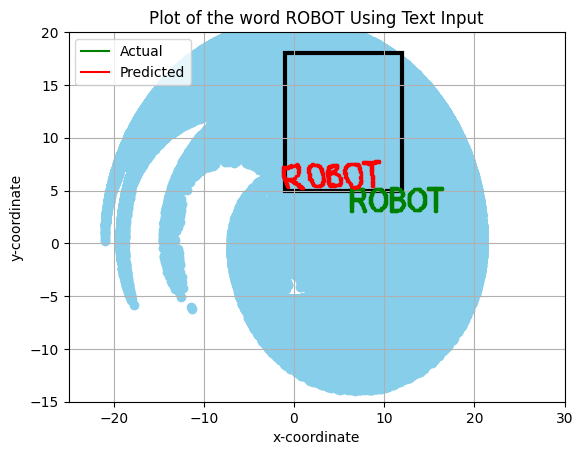

<Figure size 1500x1500 with 0 Axes>

In [61]:
plotCoordinateFile("Text_Generated/Image Generate_ROBOT.csv", 'Plot of the word ROBOT Using Text Input')

In [62]:
getPerformanceModel("Text_Generated/Image Generate_ROBOT.csv")

Mean Squared Error in x  : 0.04296929460580911
Mean Squared Error in y  : 0.14446763485477182
Mean Squared Error in q1 : 3.117815420744338
Mean Squared Error in q2 : 2.1031970792323213e-07
Mean Squared Error in q3 : 3.117963070938976
Mean Squared Error in theta : 2.0958283516491316

Root Mean Squared Error in x : 0.20729036303168827
Root Mean Squared Error in y : 0.3800889828116198
Root Mean Squared Error in q1 : 1.7657336777510753
Root Mean Squared Error in q2 : 0.0004586062667727428
Root Mean Squared Error in q3 : 1.765775487127108
Root Mean Squared Error in theta : 1.44769760366215

Mean Absolute Error in x : 0.15937759336099583
Mean Absolute Error in y : 0.34767634854771795
Mean Absolute Error in q1 : 1.5715892567043699
Mean Absolute Error in q2 : 0.0003767984399240423
Mean Absolute Error in q3 : 1.5716437577137918
Mean Absolute Error in theta : 1.2413273545510561

R2 Score for x : 0.995402759722473
R2 Score for y : 0.6804998828646442
R2 Score for q1 : -21.738680829571962
R2 Score 

Plotting the Word "ROBOTICS" from Text Input

In [63]:
text_to_image("ROBOTICS", 26, 300, 100, "Text_Generated/Text Generate_ROBOTICS.png")

In [64]:
generateCoordinateFile('Text_Generated/Text Generate_ROBOTICS.png', 'Text_Generated', "ROBOTICS")

1/1 [==============================] - 0s 19ms/step


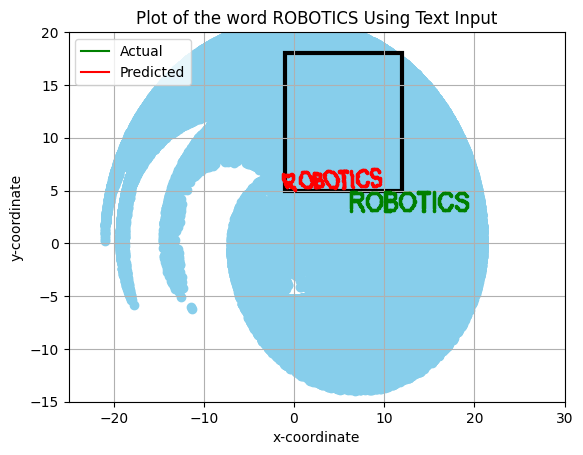

<Figure size 1500x1500 with 0 Axes>

In [65]:
plotCoordinateFile("Text_Generated/Image Generate_ROBOTICS.csv", 'Plot of the word ROBOTICS Using Text Input')

In [66]:
getPerformanceModel("Text_Generated/Image Generate_ROBOTICS.csv")

Mean Squared Error in x  : 0.04326511111111112
Mean Squared Error in y  : 0.18010422222222225
Mean Squared Error in q1 : 2.72099822242955
Mean Squared Error in q2 : 2.791001361324092e-07
Mean Squared Error in q3 : 2.7210964153278585
Mean Squared Error in theta : 2.0977974234194825

Root Mean Squared Error in x : 0.20800267092302233
Root Mean Squared Error in y : 0.4243868780042831
Root Mean Squared Error in q1 : 1.649544853112382
Root Mean Squared Error in q2 : 0.0005282992865151431
Root Mean Squared Error in q3 : 1.6495746164777931
Root Mean Squared Error in theta : 1.448377514123815

Mean Absolute Error in x : 0.17015555555555553
Mean Absolute Error in y : 0.38375555555555557
Mean Absolute Error in q1 : 1.4389243020265952
Mean Absolute Error in q2 : 0.00043255990815794566
Mean Absolute Error in q3 : 1.4389575649789614
Mean Absolute Error in theta : 1.2632455261735278

R2 Score for x : 0.9969834486136502
R2 Score for y : 0.48557916290595093
R2 Score for q1 : -12.75372036898836
R2 Scor

Plotting the Word "3 LINK" from Text Input

In [67]:
text_to_image("3 LINK", 30, 300, 100, "Text_Generated/Text Generate_3 LINK.png")

In [68]:
generateCoordinateFile('Text_Generated/Text Generate_3 LINK.png', 'Text_Generated', "3 LINK")

1/1 [==============================] - 0s 21ms/step


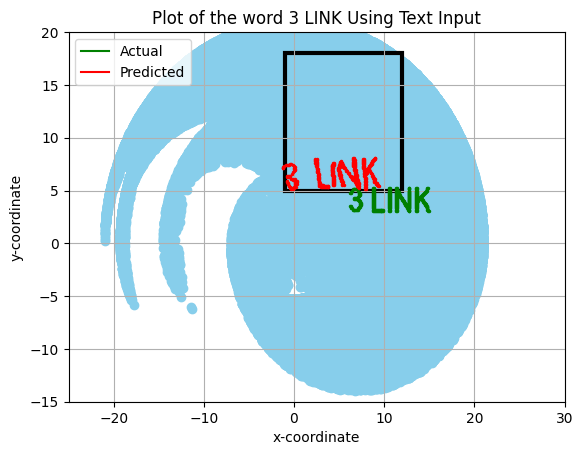

<Figure size 1500x1500 with 0 Axes>

In [69]:
plotCoordinateFile("Text_Generated/Image Generate_3 LINK.csv", 'Plot of the word 3 LINK Using Text Input')

In [70]:
getPerformanceModel("Text_Generated/Image Generate_3 LINK.csv")

Mean Squared Error in x  : 0.054726790450928285
Mean Squared Error in y  : 0.14575198938992046
Mean Squared Error in q1 : 2.9715917689865856
Mean Squared Error in q2 : 1.9106525795102994e-07
Mean Squared Error in q3 : 2.9715724759471445
Mean Squared Error in theta : 1.8014262240705596

Root Mean Squared Error in x : 0.2339375781077685
Root Mean Squared Error in y : 0.38177478883488425
Root Mean Squared Error in q1 : 1.7238305511234524
Root Mean Squared Error in q2 : 0.00043711012108052353
Root Mean Squared Error in q3 : 1.7238249551352784
Root Mean Squared Error in theta : 1.3421722035828934

Mean Absolute Error in x : 0.18122015915119358
Mean Absolute Error in y : 0.35180371352785145
Mean Absolute Error in q1 : 1.5914025326952392
Mean Absolute Error in q2 : 0.00036791947356713887
Mean Absolute Error in q3 : 1.59140294699927
Mean Absolute Error in theta : 1.1841352792791795

R2 Score for x : 0.9907741330843897
R2 Score for y : 0.6531570358161554
R2 Score for q1 : -36.74106466823115
R2 

Plotting the Word "BHOPAL" from Text Input

In [71]:
text_to_image("BHOPAL", 30, 300, 100, "Text_Generated/Text Generate_BHOPAL.png")

In [72]:
generateCoordinateFile('Text_Generated/Text Generate_BHOPAL.png', 'Text_Generated', "BHOPAL")

1/1 [==============================] - 0s 17ms/step


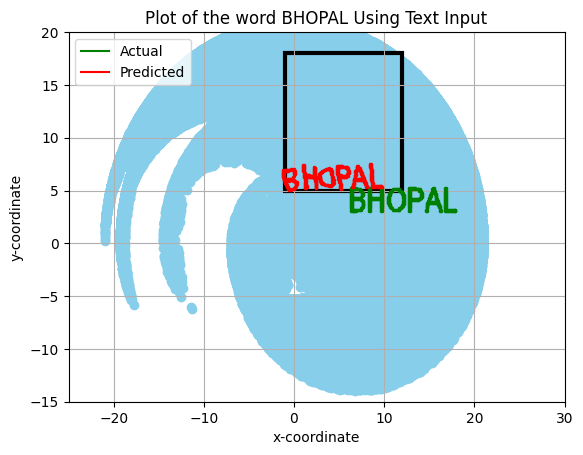

<Figure size 1500x1500 with 0 Axes>

In [73]:
plotCoordinateFile("Text_Generated/Image Generate_BHOPAL.csv", 'Plot of the word BHOPAL Using Text Input')

In [74]:
getPerformanceModel("Text_Generated/Image Generate_BHOPAL.csv")

Mean Squared Error in x  : 0.04676855123674909
Mean Squared Error in y  : 0.15814787985865728
Mean Squared Error in q1 : 2.8325319519582015
Mean Squared Error in q2 : 2.1750825140278606e-07
Mean Squared Error in q3 : 2.83252943550243
Mean Squared Error in theta : 2.0285168058812184

Root Mean Squared Error in x : 0.21626037833303882
Root Mean Squared Error in y : 0.39767811086185934
Root Mean Squared Error in q1 : 1.68301276048585
Root Mean Squared Error in q2 : 0.0004663777990028964
Root Mean Squared Error in q3 : 1.6830120128812005
Root Mean Squared Error in theta : 1.424260090672072

Mean Absolute Error in x : 0.17166077738515895
Mean Absolute Error in y : 0.36591872791519436
Mean Absolute Error in q1 : 1.4458677046438715
Mean Absolute Error in q2 : 0.0003852198193640741
Mean Absolute Error in q3 : 1.4458825326049805
Mean Absolute Error in theta : 1.227224706889065

R2 Score for x : 0.9962529411960662
R2 Score for y : 0.6130618549646281
R2 Score for q1 : -14.755492686852474
R2 Score

Plotting the Word "RESEARCH" from Text Input

In [75]:
text_to_image("RESEARCH", 26, 300, 100, "Text_Generated/Text Generate_RESEARCH.png")

In [76]:
generateCoordinateFile('Text_Generated/Text Generate_RESEARCH.png', 'Text_Generated', "RESEARCH")

1/1 [==============================] - 0s 22ms/step


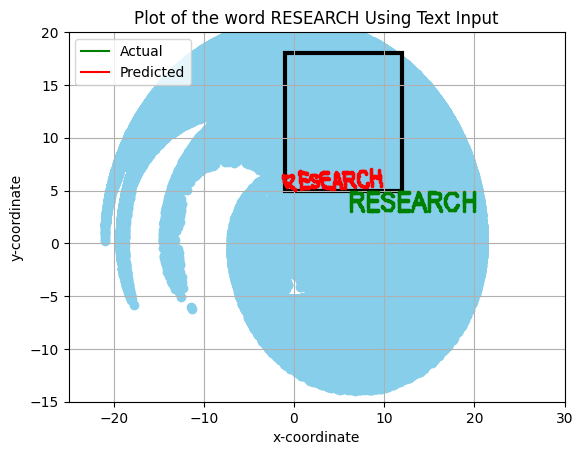

<Figure size 1500x1500 with 0 Axes>

In [77]:
plotCoordinateFile("Text_Generated/Image Generate_RESEARCH.csv", 'Plot of the word RESEARCH Using Text Input')

In [78]:
getPerformanceModel("Text_Generated/Image Generate_RESEARCH.csv")

Mean Squared Error in x  : 0.053499999999999985
Mean Squared Error in y  : 0.19856064638783272
Mean Squared Error in q1 : 2.5072118722271783
Mean Squared Error in q2 : 4.1148778608009676e-07
Mean Squared Error in q3 : 2.5071813465373785
Mean Squared Error in theta : 2.117577390560138

Root Mean Squared Error in x : 0.23130067012440753
Root Mean Squared Error in y : 0.44560144343104713
Root Mean Squared Error in q1 : 1.5834177819600166
Root Mean Squared Error in q2 : 0.0006414731374579116
Root Mean Squared Error in q3 : 1.5834081427532758
Root Mean Squared Error in theta : 1.4551898125537224

Mean Absolute Error in x : 0.18418250950570336
Mean Absolute Error in y : 0.40880228136882135
Mean Absolute Error in q1 : 1.3562437967792715
Mean Absolute Error in q2 : 0.0004893699417487451
Mean Absolute Error in q3 : 1.3562086400416637
Mean Absolute Error in theta : 1.2706766756052976

R2 Score for x : 0.9967264961743912
R2 Score for y : 0.423439039216287
R2 Score for q1 : -9.620129387258645
R2 S